# Trabajo Práctico 3

Integrantes:
* Bayardo Spadafora, Julián. LU: 850/13. Email: julian@bayardo.info
* Cuneo, Christian. LU: 755/13. Email: chriscuneo93@gmail.com

Fecha de Entrega: 09/08/2017

# Ejercicio 1

Para resolver este ejercicio, utilizamos la solución obtenida por Cuadrados Mínimos del vector de pesos para el discriminante de Fisher[1]. En la siguiente formulación, tomamos a $N$ como la cantidad de muestras, $N_1$ como la cantidad de muestras de clase $C_1$ y $N_2$ como la cantidad de muestras de clase $C_2$.

Bishop comenta que si reemplazamos a los targets $t_i$ por $\frac{N}{N_1}$ en el caso de $C_1$ y $\frac{-N}{N_2}$ en el caso de $C_2$, podemos reformular la solución al problema del discriminante de Fisher como la minimización del error cuadrático medio:

$$E(w) = \frac{1}{2}\sum_{n=1}^N (w^T x_n + w_0 - t_n)^2$$

Y al obtener las derivadas con respecto a $w_0$ y $w$ e igualar a $0$, obtenemos:

$$w_0 = -w^T m$$

Donde $m = \frac{1}{N} \sum_{n=1}^N x_n$ es el promedio de todo el conjunto de datos, y además:

$$(S_W + \frac{N_1 N_2}{N} S_B) w = N (m_1 - m_2)$$

Donde $S_W$ es la matriz de covarianza dentro de las clases, $S_B$ es la matriz de covarianca intra clase, y los $m_i$ son los promedios de cada una de las clases. De esto se sigue que:

$$S_W w + \frac{N_1 N_2}{N} S_B w = N (m_1 - m_2)$$

Pero $S_B w$ es paralelo a $(m_1 - m_2)$, por lo que tenemos que

$$S_W w = \alpha (m_1 - m_2)$$

O, equivalentemente

$$w = \alpha S_W^{-1} (m_1 - m_2)$$

Donde $\alpha$ contiene a la constante dada por el hecho de ser paralelos multiplicada por las otras constantes en la ecuación. Cabe destacar que basta con tomar $S_W^{-1} (m_1 - m_2)$ como $w^*$,  ya que $J$

[1] Christopher M. Bishop, "Pattern Recognition and Machine Learning", Springer, 2006. Sección 4.1.5, Página 190.

In [128]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.stats
import scipy.linalg
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set(color_codes=True)

def fisher_2class(X, Y):
    # X looks like a matrix
    assert len(X.shape) == 2
    # X has at one row
    assert X.shape[0] > 0
    # X has at least two features
    assert X.shape[1] >= 2
    # Sw is going to be invertible
    assert X.shape[1] < X.shape[0]

    # Y is an array
    assert len(Y.shape) == 1
    # Y has exactly one element per entry in the dataset
    assert Y.shape[0] == X.shape[0]
    
    # Fetch unique classes
    classes = np.unique(Y)
    # We have exactly two classes
    assert len(classes) == 2
    
    means = np.zeros(shape=(len(classes), X.shape[1]))
    Sw = np.zeros(shape=(X.shape[1], X.shape[1]))
    # Process each class separately
    for index, c in enumerate(classes):
        # Indexes that have class `c`
        discriminator = np.where(Y==c)
        # Compute the mean for the class
        means[index] = np.mean(X[discriminator], axis=0)
        # Add up the local within-class covariance to the total within-class covariance matrix
        Sw += np.cov(np.transpose(X[discriminator] - means[index]))
    
    # Compute `w` as seen in the above cell
    w = np.matmul(np.linalg.inv(Sw), means[1] - means[0])
    # The weight vector has exactly one weight per feature
    assert w.shape[0] == X.shape[1]
    mean = np.mean(X, axis=0)
    w0 = -np.matmul(w, mean)
    # TODO: return class mapping.
    return w, w0

# Ejercicio 2

Para esta implementación, seguimos la metodología de Duda, Hart y Stork[1], utilizando como base la implementación del ejercicio anterior.

Cabe destacar que en esta implementación no estamos haciendo uso de multiples clasificadores de dos clases, sino que tenemos una única función discriminante de C clases. Es decir, no tenemos los problemas expuestos en clase de regiones sin clasificación clara, y además nuestras regiones de clasificación son convexas.

[1] R. O. Duda, P. E. Hart, D. G. Stork. Pattern Classification(Second Edition). John Wiley & Sons, Inc., New York, 2001. ISBN 0-471-05669-3.

In [144]:
def fisher_Cclass(X, Y):
    # X looks like a matrix
    assert len(X.shape) == 2
    # X has at one row
    assert X.shape[0] > 0
    # X has at least two features
    assert X.shape[1] >= 2
    # Sw is going to be invertible
    assert X.shape[1] < X.shape[0]

    # Y is an array
    assert len(Y.shape) == 1
    # Y has exactly one element per entry in the dataset
    assert Y.shape[0] == X.shape[0]
    
    # Fetch unique classes
    classes = np.unique(Y)
    # We have exactly two classes
    assert len(classes) > 2
    
    means = np.zeros(shape=(len(classes), X.shape[1]))
    St = np.cov(np.transpose(X))
    Sw = np.zeros(shape=(X.shape[1], X.shape[1]))
    # Process each class separately
    for index, c in enumerate(classes):
        # Indexes that have class `c`
        discriminator = np.where(Y==c)
        # Compute the mean for the class
        means[index] = np.mean(X[discriminator], axis=0)
        # Add up the local within-class covariance to the total within-class covariance matrix
        Sw += np.cov(np.transpose(X[discriminator] - means[index]))
    Sb = St - Sw
    
    # Solve the generalized eigenvalue problem
    eigenvalues, eigenvectors = sp.linalg.eigh(Sb, Sw)
    # Sort them according to largest eigenvalue
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
    # Normalize the eigenvectors
    eigenvectors /= np.apply_along_axis(np.linalg.norm, 0, eigenvectors)

    W = np.dot(means, eigenvectors).dot(eigenvectors.T)
    w0= -0.5 * np.diag(np.dot(means, W.T))
    return W, w0

# Ejercicio 3

Como vimos en la clase teórica, si los datos provienen de una Gaussiana multivariada isotrópica, entonces el vector $w$ poseerá la dirección que une a los centros de las clases.

In [241]:
# These are configuration parameters
DATASET_SIZE = 1000
TRAIN_RELATIVE_SIZE = 0.1
INPUT_DIMENSIONS = 2
DIMENSION_RANGES = np.array([[-10.0, -10.0], [10.0, 10.0]])
DIMENSION_PLOT_RANGE_PRECISION = 0.25
LABEL_COLORS=['blue', 'red', 'white', 'yellow']

def isotropic_normal(mean, variance):
    assert len(mean) >= 1
    return sp.stats.multivariate_normal(mean=mean, cov=variance * np.identity(len(mean)))

DISTRIBUTIONS = [
    isotropic_normal([5.0, -5.0], 5),
#    isotropic_normal([5.0, 5.0], 0.5),
#    isotropic_normal([-5.0, -5.0], 0.75),
    isotropic_normal([-5.0, 5.0], 1.0)]

assert DATASET_SIZE >= 1
assert INPUT_DIMENSIONS >= 2
assert DIMENSION_RANGES.shape == (2, INPUT_DIMENSIONS)
assert 0.0 < TRAIN_RELATIVE_SIZE <= 1.0
assert len(DISTRIBUTIONS) >= 2
assert all([d.dim == INPUT_DIMENSIONS for d in DISTRIBUTIONS])
assert len(DISTRIBUTIONS) <= len(LABEL_COLORS)

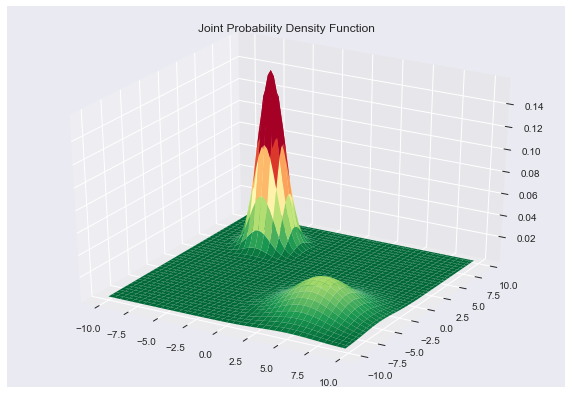

In [242]:
if INPUT_DIMENSIONS == 2:
    x = np.arange(DIMENSION_RANGES[0][0], DIMENSION_RANGES[1][0], DIMENSION_PLOT_RANGE_PRECISION)
    y = np.arange(DIMENSION_RANGES[0][1], DIMENSION_RANGES[1][1], DIMENSION_PLOT_RANGE_PRECISION)
    X, Y = np.meshgrid(x, y)
    zs = np.array([max([dist.pdf([x, y]) for dist in DISTRIBUTIONS]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    # Graph the surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Joint Probability Density Function')

    ax.plot_surface(X, Y, Z, color='b', vmin=0, vmax=0.1, cmap='RdYlGn_r')

In [243]:
# Sample from the process that generates the dataset
def generate_data(DATASET_SIZE, DISTRIBUTIONS):
    X = []
    Y = []
    for _ in range(DATASET_SIZE):
        # Fetch one of our chosen distributions, this will be the label
        y = np.random.randint(len(DISTRIBUTIONS))
        # Generate a random point sampled from it
        x = DISTRIBUTIONS[y].rvs(size=1)
        Y.append(y)
        X.append(x)

    # Convert into numpy format, this is what we are going to use for training
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

def classify(w, w0, X):
    # Run all the data through the classifier
    predicted = np.dot(X, w.T) + w0
    if len(DISTRIBUTIONS) > 2:
        return np.argmax(predicted, axis=1)
    else:
        return np.array([int(p >= 0) for p in predicted])

# Train the classifier
X, Y = generate_data(DATASET_SIZE, DISTRIBUTIONS)
selection_mask = np.random.rand(DATASET_SIZE) < TRAIN_RELATIVE_SIZE
w, w0 = fisher_2class(X[selection_mask], Y[selection_mask])
labels = classify(w, w0, X)
predictions = np.vstack((labels, Y)).T

In [244]:
# Transform the data into a format more amenable for plotting
df = pd.concat([
        pd.DataFrame(X,
                     columns=['x' + str(i) for i in range(INPUT_DIMENSIONS)]),
        pd.DataFrame(predictions,
                     columns=['predicted_label',
                              'label']),
        pd.DataFrame(selection_mask,
                     columns=['is_training_data'])],
    axis=1)

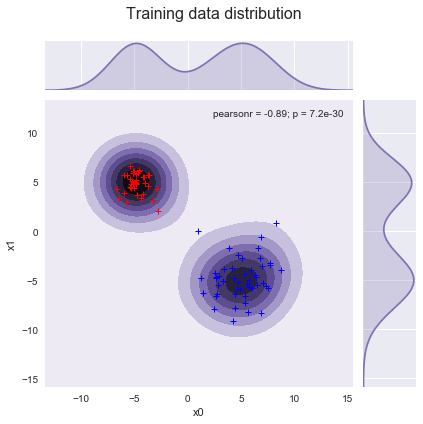

In [245]:
# Plot the input dataset and labelled samples
if INPUT_DIMENSIONS == 2:
    plot_df = df[df['is_training_data'] == True]
    plot = sns.jointplot(x="x0", y="x1", data=plot_df, kind='kde',
                         color='m')
    plot.fig.subplots_adjust(top=0.9)
    plot.fig.suptitle('Training data distribution', fontsize=16)
    labels = np.unique(Y)
    for index, label in enumerate(labels):
        intermediate = plot_df[plot_df['label'] == label]
        plot.ax_joint.scatter(intermediate['x0'], intermediate['x1'],
                              s=30, linewidth=1, marker='+',
                              color=LABEL_COLORS[index])

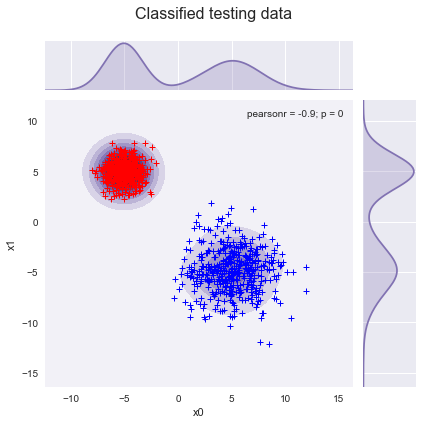

In [246]:
# Plot the testing data and the classification output
if INPUT_DIMENSIONS == 2:
    plot_df = df[df['is_training_data'] == False]
    plot = sns.jointplot(x="x0", y="x1", data=plot_df, kind='kde',
                         color='m')
    plot.fig.subplots_adjust(top=0.9)
    plot.fig.suptitle('Classified testing data', fontsize=16)
    labels = np.unique(Y)
    for index, label in enumerate(labels):
        intermediate = plot_df[plot_df['predicted_label'] == label]
        plot.ax_joint.scatter(intermediate['x0'], intermediate['x1'],
                              s=30, linewidth=1, marker='+',
                              color=LABEL_COLORS[index])

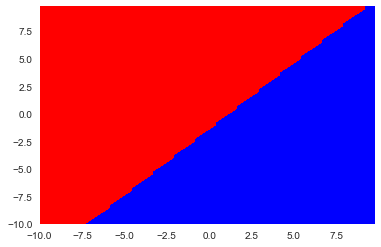

In [247]:
# Plot the classification boundaries
if INPUT_DIMENSIONS == 2:
    import matplotlib.colors

    x = np.arange(DIMENSION_RANGES[0][0], DIMENSION_RANGES[1][0], DIMENSION_PLOT_RANGE_PRECISION)
    y = np.arange(DIMENSION_RANGES[0][1], DIMENSION_RANGES[1][1], DIMENSION_PLOT_RANGE_PRECISION)
    X, Y = np.meshgrid(x, y)
    Z = classify(w, w0, np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    plt.contourf(X, Y, Z, cmap=matplotlib.colors.ListedColormap(LABEL_COLORS[:len(DISTRIBUTIONS)]))

# Ejercicio 4